In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Datasets/AirQualityUCI.xlsx')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [5]:
df['DateTime'] = df['Date'].astype('str') + ' ' + df['Time'].astype('str')

In [6]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [7]:
df.set_index('DateTime', inplace=True)

## Check for any missing datetime in the index

In [8]:
df.index.max() , df.index.min()

(Timestamp('2005-04-04 14:00:00'), Timestamp('2004-03-10 18:00:00'))

In [9]:
df.index.max() - df.index.min()

Timedelta('389 days 20:00:00')

In [10]:
print('Total number of observations in the dataframe: ', df.shape[0])
print('Total counted datetime: ', (389 * 24 + 20))

Total number of observations in the dataframe:  9357
Total counted datetime:  9356


In [11]:
# this will print any missing datetime in dataframe df
pd.date_range(start = df.index.min(), end = df.index.min(), freq='H').difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [12]:
print(df.index.inferred_freq)

H


In [13]:
m = df.copy()

In [14]:
m.drop(['2004-03-10 19:00:00', '2004-03-10 21:00:00', '2005-04-04 13:00:00'], inplace=True)

In [15]:
m.shape

(9354, 15)

In [16]:
# this will print any missing datetime in dataframe m
pd.date_range(start =m.index.min(), end =m.index.max(), freq='H').difference(m.index)

DatetimeIndex(['2004-03-10 19:00:00', '2004-03-10 21:00:00',
               '2005-04-04 13:00:00'],
              dtype='datetime64[ns]', freq=None)

In [17]:
m.index.inferred_freq

<b>So the dataset has no missing time index.</b>

# Feature Engineering

In [18]:
df.replace(-200, np.nan, inplace=True)

In [19]:
# more than 90% of values are missing from NMHC(GT) column
df.drop('NMHC(GT)', axis=1, inplace=True)

In [20]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [21]:
for col in df.columns[2:]:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  upper_limit = Q3 + 1.5 * IQR
  lower_limit = Q1 - 1.5 * IQR
  df[col] = np.where(df[col]>upper_limit, upper_limit, np.where(df[col]<lower_limit, lower_limit, df[col]))


In [22]:
# replacing missing values using linear interpolation
for col in df.columns[2:]:
  df[col] = df[col].interpolate()

In [23]:
df.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

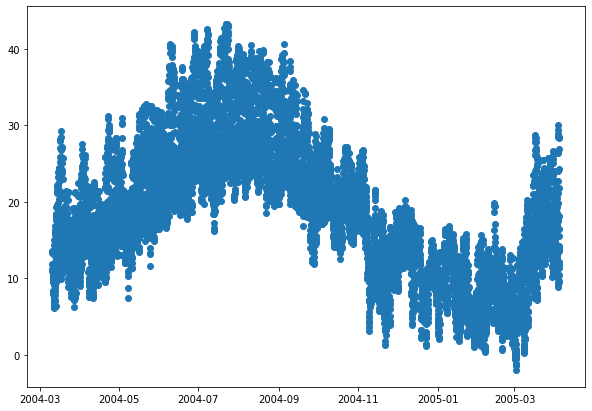

In [24]:
plt.figure(figsize=(10,7))
plt.scatter(x=df.index, y=df['T'])

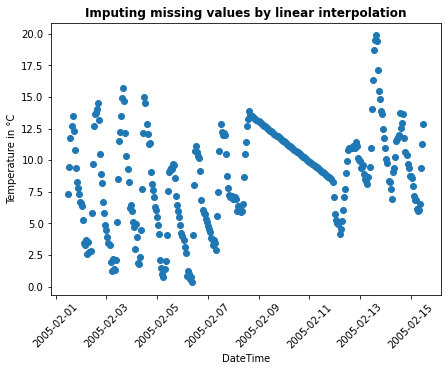

In [25]:
plt.figure(figsize=(7,5))
plt.scatter(x=df['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=df['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'])
plt.title('Imputing missing values by linear interpolation', fontweight='bold')
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45);

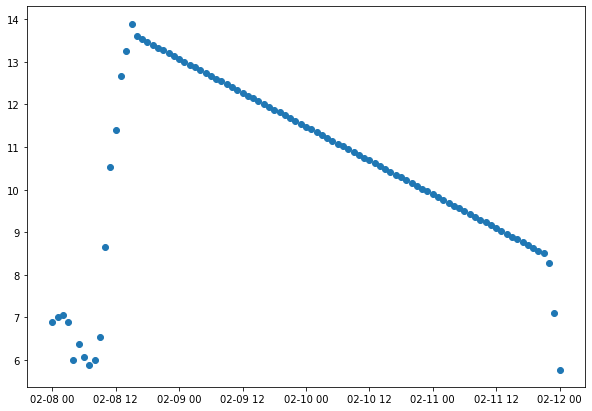

In [26]:
plt.figure(figsize=(10,7))
plt.scatter(x=df['T'].loc['2005-02-08 00:00:00':'2005-02-12 00:00:00'].index, y=df['T'].loc['2005-02-08 00:00:00':'2005-02-12 00:00:00'])

<b>The straight line formed by a sequence of points on the above plot is because of values generated in place of NAN values by linear interpolation technique, where NAN values are substituted in place of -200 values.</b>

<b>Let's try other techniques to impute missing values.</b>

In [27]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Datasets/AirQualityUCI.xlsx')
data['DateTime'] = data['Date'].astype('str') + ' ' + data['Time'].astype('str')
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

In [28]:
data['T'].loc['2005-02-08 12:00:00':'2005-02-12 00:00:00'].head(10)

DateTime
2005-02-08 12:00:00     11.400
2005-02-08 13:00:00     12.675
2005-02-08 14:00:00     13.250
2005-02-08 15:00:00     13.900
2005-02-08 16:00:00     13.600
2005-02-08 17:00:00   -200.000
2005-02-08 18:00:00   -200.000
2005-02-08 19:00:00   -200.000
2005-02-08 20:00:00   -200.000
2005-02-08 21:00:00   -200.000
Name: T, dtype: float64

In [29]:
data.replace(-200, np.nan, inplace=True)

In [30]:
data.drop('NMHC(GT)', inplace=True, axis=1)

In [31]:
# treating outliers by flooring and capping
for col in data.columns[2:]:
  Q1 = data[col].quantile(0.25)
  Q3 = data[col].quantile(0.75)
  IQR = Q3 - Q1
  upper_limit = Q3 + 1.5 * IQR
  lower_limit = Q1 - 1.5 * IQR
  data[col] = np.where(data[col]>upper_limit, upper_limit, np.where(data[col]<lower_limit, lower_limit, data[col]))


In [32]:
d1 = data.copy()
d2 = data.copy()
d3 = data.copy()
d4 = data.copy()
d5 = data.copy()
d6 = data.copy()
d7 = data.copy()
d8 = data.copy()
d9 = data.copy()
d10 = data.copy()

In [33]:
# replacing missing values using spline interpolation
for col in d1.columns[2:]:
  d1[col] = d1[col].interpolate(method='spline', order=3)

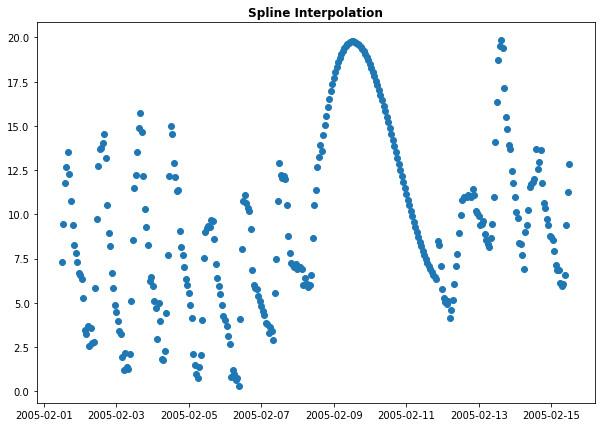

In [34]:
plt.figure(figsize=(10,7))
plt.title('Spline Interpolation', fontweight='bold')
plt.scatter(x=d1['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=d1['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'])

In [35]:
# replacing missing values using quadratic interpolation
for col in d2.columns[2:]:
  d2[col] = d2[col].interpolate(method='quadratic')

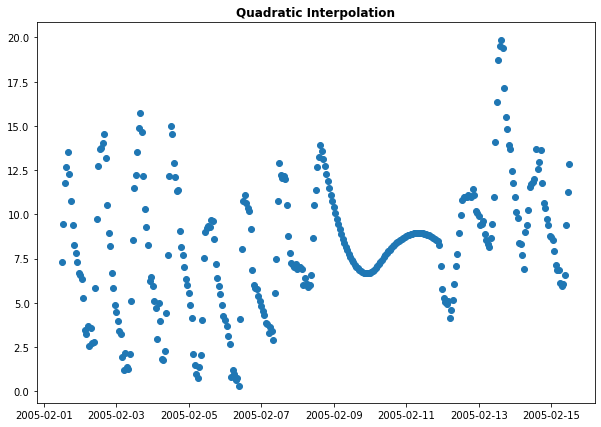

In [36]:
plt.figure(figsize=(10, 7))
plt.title('Quadratic Interpolation', fontweight='bold')
plt.scatter(x=d2['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=d2['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'])

In [37]:
# replacing missing values using barycentric interpolation
for col in d3.columns[2:]:
  d3[col] = d3[col].interpolate(method='barycentric')

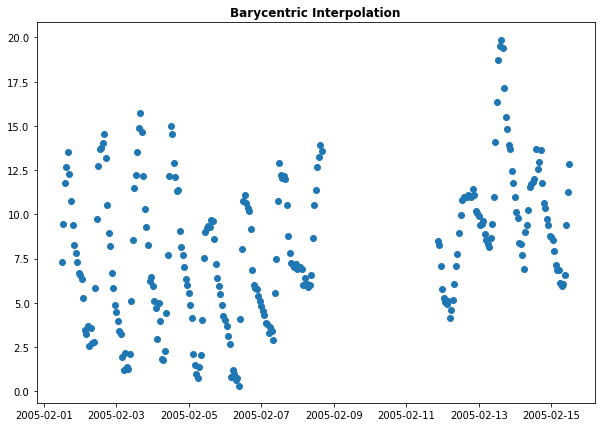

In [38]:
plt.figure(figsize=(10, 7))
plt.title('Barycentric Interpolation', fontweight='bold')
plt.scatter(x=d3['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=d3['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'])

In [39]:
# replacing missing values using cubic interpolation
for col in d4.columns[2:]:
  d4[col] = d4[col].interpolate(method='cubic')

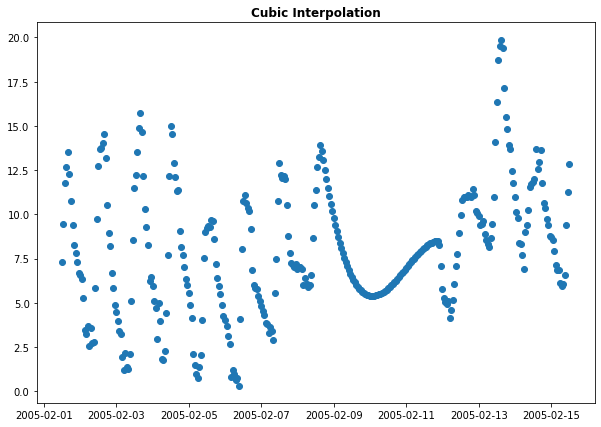

In [40]:
plt.figure(figsize=(10, 7))
plt.title('Cubic Interpolation', fontweight='bold')
plt.scatter(x=d4['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=d4['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'])

In [41]:
# replacing missing values using nearest interpolation
for col in d5.columns[2:]:
  d5[col] = d5[col].interpolate(method='nearest')

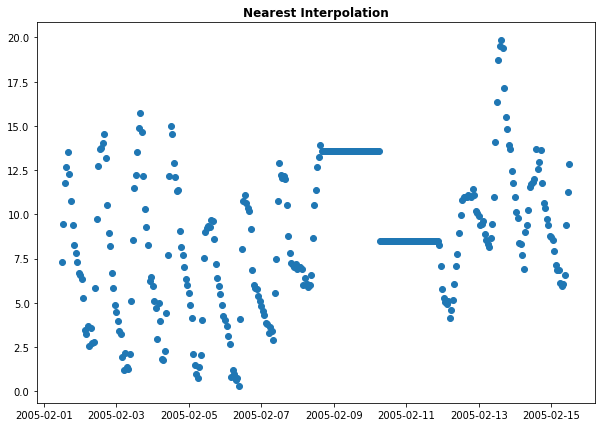

In [42]:
plt.figure(figsize=(10, 7))
plt.title('Nearest Interpolation', fontweight='bold')
plt.scatter(x=d5['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=d5['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'])

In [43]:
# akima interpolation
for col in d6.columns[2:]:
  d6[col] = d6[col].interpolate(method='akima')

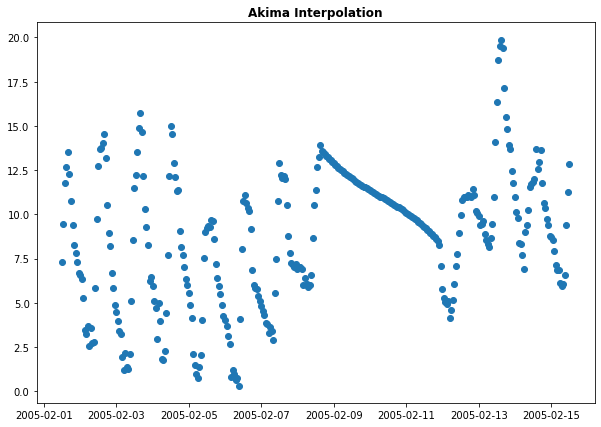

In [44]:
plt.figure(figsize=(10, 7))
plt.title('Akima Interpolation', fontweight='bold')
plt.scatter(x=d6['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=d6['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'])

In [45]:
# slinear interpolation
for col in d7.columns[2:]:
  d7[col] = d7[col].interpolate(method='slinear')

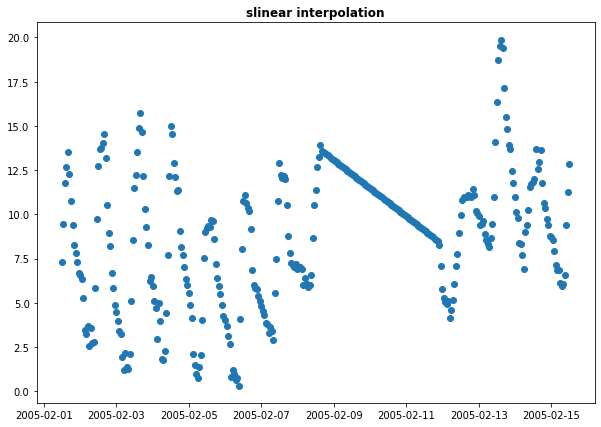

In [46]:
plt.figure(figsize=(10, 7))
plt.title('slinear interpolation', fontweight='bold')
plt.scatter(x=d7['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=d7['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'])

In [47]:
# replace missing values using rolling mean
d8['T_rollingmean5'] = d8['T'].rolling(min_periods=1, center=True, window=82).mean()
d8['T_sma'] = d8['T_rollingmean5']
d8['T_sma'].update(d8['T']) # inplace operation

In [48]:
d8.head(2)

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,T_rollingmean5,T_sma
DateTime,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2004-03-10,18:00:00,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754,9.600610,13.6
2004-03-10 19:00:00,2004-03-10,19:00:00,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487,9.713095,13.3


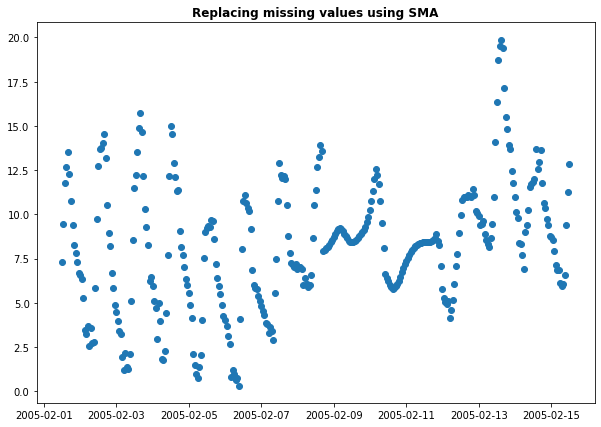

In [49]:
plt.figure(figsize=(10, 7))
plt.title('Replacing missing values using SMA', fontweight='bold')
plt.scatter(x=d8['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=d8['T_sma'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00']);

In [50]:
# using exponentially weighted moving average
d9['T'] = d9['T'].ewm(halflife=5).mean()

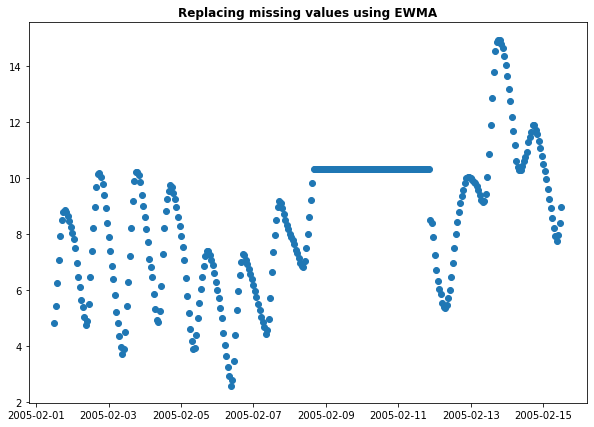

In [51]:
plt.figure(figsize=(10, 7))
plt.title('Replacing missing values using EWMA', fontweight='bold')
plt.scatter(x=d9['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=d9['T'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'])

In [52]:
# Filling missing values by the hourly median of each month
d10['Month'] = d10.Date.dt.month
d10['T_median'] = d10.groupby(['Month', 'Time'])['T'].transform(lambda x:x.fillna(x.median()))

In [53]:
d10[['T', 'T_median']].loc['2005-02-08 12:00:00':'2005-02-12 12:00:00'].head(10)

,T,T_median
DateTime,,
2005-02-08 12:00:00,11.400,11.4000
2005-02-08 13:00:00,12.675,12.6750
2005-02-08 14:00:00,13.250,13.2500
2005-02-08 15:00:00,13.900,13.9000
2005-02-08 16:00:00,13.600,13.6000
2005-02-08 17:00:00,NaN,9.9125
2005-02-08 18:00:00,NaN,8.5500
2005-02-08 19:00:00,NaN,7.7125
2005-02-08 20:00:00,NaN,7.3750


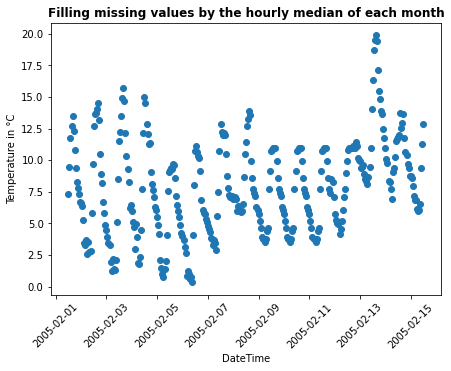

In [54]:
plt.figure(figsize=(7,5))
plt.title('Filling missing values by the hourly median of each month', fontweight='bold')
plt.scatter(x=d10['T_median'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'].index, y=d10['T_median'].loc['2005-02-01 12:00:00':'2005-02-15 12:00:00'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45);


<b>Imputing missing values using the hourly median of each month is doing quite decent job as compared to others....  so ww'll go with it to substitute missing values in other columns too.</b>

In [55]:
# Filling missing values by the hourly median of each month
data['Month'] = data.Date.dt.month
for col in data.columns:
  if col not in ['Date', 'Time', 'Month']:
    data[col+'_median'] = data.groupby(['Month', 'Time'])[col].transform(lambda x:x.fillna(x.median()))

In [56]:
data.isna().sum()

Date                       0
Time                       0
CO(GT)                  1683
PT08.S1(CO)              366
C6H6(GT)                 366
PT08.S2(NMHC)            366
NOx(GT)                 1639
PT08.S3(NOx)             366
NO2(GT)                 1642
PT08.S4(NO2)             366
PT08.S5(O3)              366
T                        366
RH                       366
AH                       366
Month                      0
CO(GT)_median             31
PT08.S1(CO)_median         0
C6H6(GT)_median            0
PT08.S2(NMHC)_median       0
NOx(GT)_median           274
PT08.S3(NOx)_median        0
NO2(GT)_median           274
PT08.S4(NO2)_median        0
PT08.S5(O3)_median         0
T_median                   0
RH_median                  0
AH_median                  0
dtype: int64

In [57]:
data['CO(GT)'] = data['CO(GT)_median']
data['PT08.S1(CO)'] = data['PT08.S1(CO)_median']
data['C6H6(GT)'] = data['C6H6(GT)_median']
data['PT08.S2(NMHC)'] = data['PT08.S2(NMHC)_median']
data['NOx(GT)'] = data['NOx(GT)_median']
data['PT08.S3(NOx)'] = data['PT08.S3(NOx)_median'] 
data['NO2(GT)'] = data['NO2(GT)_median']
data['PT08.S4(NO2)'] = data['PT08.S4(NO2)_median']
data['PT08.S5(O3)'] = data['PT08.S5(O3)_median']
data['T'] = data['T_median']
data['RH'] = data['RH_median'] 
data['AH'] = data['AH_median']

In [58]:
data.drop(['CO(GT)_median', 'PT08.S1(CO)_median', 'C6H6(GT)_median', 'PT08.S2(NMHC)_median', 'NOx(GT)_median', 'PT08.S3(NOx)_median', 
           'NO2(GT)_median', 'PT08.S4(NO2)_median', 'PT08.S5(O3)_median', 'T_median', 'AH_median', 'RH_median'], axis=1, inplace=True)

In [59]:
data.isna().sum()

Date               0
Time               0
CO(GT)            31
PT08.S1(CO)        0
C6H6(GT)           0
PT08.S2(NMHC)      0
NOx(GT)          274
PT08.S3(NOx)       0
NO2(GT)          274
PT08.S4(NO2)       0
PT08.S5(O3)        0
T                  0
RH                 0
AH                 0
Month              0
dtype: int64

In [60]:
data.loc[data['CO(GT)'].isnull()]

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month
DateTime,,,,,,,,,,,,,,,
2004-05-01 04:00:00,2004-05-01,04:00:00,NaN,882.25,3.542514,684.75,35.0,1133.5000,42.0,1492.00,672.75,16.175000,69.900000,1.275573,5
2004-05-02 04:00:00,2004-05-02,04:00:00,NaN,854.25,3.297505,670.25,26.0,1141.2500,35.0,1460.00,683.50,14.825000,65.800001,1.102810,5
2004-05-03 04:00:00,2004-05-03,04:00:00,NaN,875.50,1.528069,547.00,25.0,1256.2500,33.0,1351.00,504.75,15.950000,61.374999,1.104294,5
2004-05-04 04:00:00,2004-05-04,04:00:00,NaN,880.75,1.519090,546.25,21.0,1334.5000,28.0,1465.00,457.75,15.550000,81.025002,1.421615,5
2004-05-05 04:00:00,2004-05-05,04:00:00,NaN,866.50,2.059523,588.50,28.0,1266.7500,41.0,1439.00,468.25,14.675000,74.099998,1.230171,5
2004-05-06 04:00:00,2004-05-06,04:00:00,NaN,758.25,1.186720,517.00,15.0,1436.3125,22.0,1294.00,350.75,13.100000,67.125000,1.007936,5
2004-05-07 04:00:00,2004-05-07,04:00:00,NaN,831.00,2.246786,602.00,32.0,1269.0000,41.0,1385.75,535.25,14.000000,67.825001,1.078724,5
2004-05-08 04:00:00,2004-05-08,04:00:00,NaN,771.75,1.200205,518.25,30.0,1436.3125,41.0,1202.25,343.25,10.875000,67.549998,0.878532,5
2004-05-09 04:00:00,2004-05-09,04:00:00,NaN,1024.75,8.369357,914.25,30.0,855.7500,41.0,1605.00,1003.00,12.325000,68.049999,0.972180,5


In [61]:
data.loc[data['NOx(GT)'].isnull()]

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month
DateTime,,,,,,,,,,,,,,,
2004-05-01 03:00:00,2004-05-01,03:00:00,1.3,1009.25,6.280934,824.75,NaN,950.00,NaN,1628.50,937.75,15.650,73.075001,1.290231,5
2004-05-02 03:00:00,2004-05-02,03:00:00,1.6,999.75,6.573944,838.00,NaN,909.50,NaN,1580.00,942.00,14.850,67.625000,1.135192,5
2004-05-03 03:00:00,2004-05-03,03:00:00,0.4,871.50,1.734437,563.75,NaN,1284.00,NaN,1385.00,493.50,15.600,65.250000,1.148449,5
2004-05-04 03:00:00,2004-05-04,03:00:00,0.4,872.50,1.498227,544.50,NaN,1307.50,NaN,1471.00,497.00,15.650,81.000002,1.430156,5
2004-05-05 03:00:00,2004-05-05,03:00:00,0.5,841.50,1.753459,565.25,NaN,1326.75,NaN,1398.75,436.50,15.475,66.949999,1.169125,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-02-24 03:00:00,2005-02-24,03:00:00,0.7,894.50,1.498227,544.50,NaN,1079.75,NaN,963.50,684.75,4.250,80.950001,0.676972,2
2005-02-25 03:00:00,2005-02-25,03:00:00,1.1,1009.75,3.444460,679.00,NaN,854.00,NaN,1045.75,889.25,5.000,82.949999,0.730029,2
2005-02-26 03:00:00,2005-02-26,03:00:00,2.1,1082.00,6.680370,842.75,NaN,728.75,NaN,1061.25,1089.75,2.775,73.975000,0.559097,2


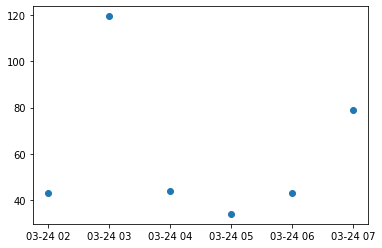

In [62]:
plt.scatter(x=data['NOx(GT)'].loc['2004-03-24 02:00:00':'2004-03-24 07:00:00'].index, y=data['NOx(GT)'].loc['2004-03-24 02:00:00':'2004-03-24 07:00:00']);

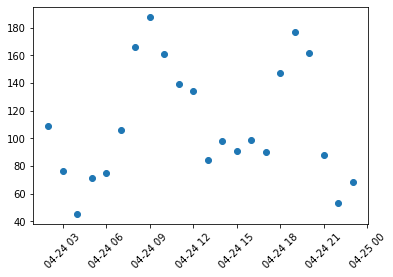

In [63]:
plt.scatter(x=data['NOx(GT)'].loc['2004-04-24 02:00:00':'2004-04-24 23:00:00'].index, y=data['NOx(GT)'].loc['2004-04-24 02:00:00':'2004-04-24 23:00:00'])
plt.xticks(rotation=45);

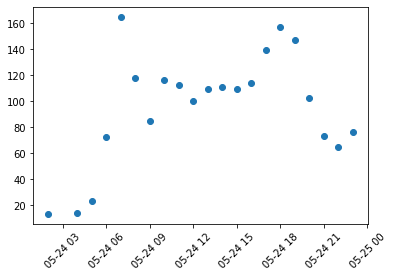

In [64]:
plt.scatter(x=data['NOx(GT)'].loc['2004-05-24 02:00:00':'2004-05-24 23:00:00'].index, y=data['NOx(GT)'].loc['2004-05-24 02:00:00':'2004-05-24 23:00:00'])
plt.xticks(rotation=45);

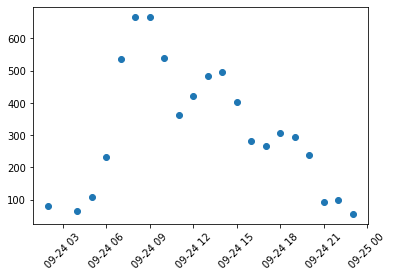

In [65]:
plt.scatter(x=data['NOx(GT)'].loc['2004-09-24 02:00:00':'2004-09-24 23:00:00'].index, y=data['NOx(GT)'].loc['2004-09-24 02:00:00':'2004-09-24 23:00:00'])
plt.xticks(rotation=45);

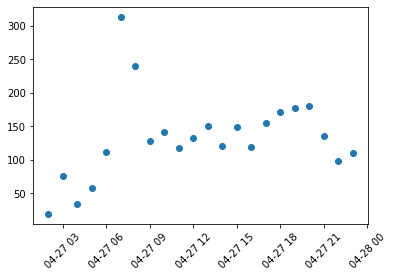

In [66]:
plt.scatter(x=data['NOx(GT)'].loc['2004-04-27 02:00:00':'2004-04-27 23:00:00'].index, y=data['NOx(GT)'].loc['2004-04-27 02:00:00':'2004-04-27 23:00:00'])
plt.xticks(rotation=45);

In [67]:
! pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
import missingno as mn

<Axes: >

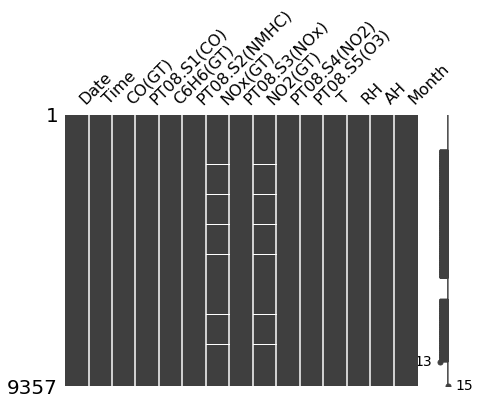

In [69]:
mn.matrix(data, figsize=(7,5))

In [70]:
data.isna().sum()

Date               0
Time               0
CO(GT)            31
PT08.S1(CO)        0
C6H6(GT)           0
PT08.S2(NMHC)      0
NOx(GT)          274
PT08.S3(NOx)       0
NO2(GT)          274
PT08.S4(NO2)       0
PT08.S5(O3)        0
T                  0
RH                 0
AH                 0
Month              0
dtype: int64

In [71]:
# now rest of the missing values can be filled using interpolation
for col in ['CO(GT)', 'NO2(GT)', 'NOx(GT)']:
  data[col] = data[col].interpolate()

In [72]:
data.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Month            0
dtype: int64

Finally, the data has no missing values.

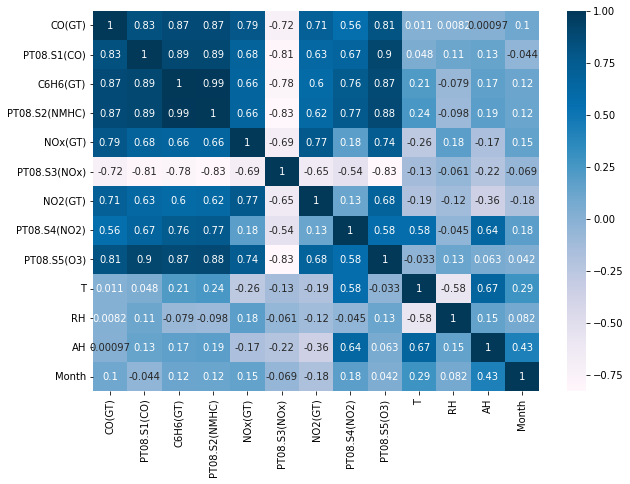

In [73]:
plt.figure(figsize=(10, 7))
sns.heatmap(data.corr(), annot=True, cmap='PuBu');

In [74]:
# create a dataframe df using Date, Time and only the highly correlated features with temperature 'T' from dataframe 'data'
df = data[['Date', 'Time', 'PT08.S4(NO2)', 'T', 'RH', 'AH', ]]

In [75]:
# create lag features
df[['PT08.S4_lag24', 'T_lag24', 'RH_lag24', 'AH_lag24']] = data[['PT08.S4(NO2)', 'T', 'RH', 'AH', ]].shift(24)

In [76]:
df.dropna(axis=0, inplace=True)

In [77]:
df.head()

,Date,Time,PT08.S4(NO2),T,RH,AH,PT08.S4_lag24,T_lag24,RH_lag24,AH_lag24
DateTime,,,,,,,,,,
2004-03-11 18:00:00,2004-03-11,18:00:00,2083.00,10.350,64.174999,0.806544,1692.00,13.60,48.875001,0.757754
2004-03-11 19:00:00,2004-03-11,19:00:00,2332.50,9.650,69.300001,0.831921,1558.75,13.30,47.700000,0.725487
2004-03-11 20:00:00,2004-03-11,20:00:00,2191.25,9.650,67.750000,0.813314,1554.50,11.90,53.975000,0.750239
2004-03-11 21:00:00,2004-03-11,21:00:00,1706.50,9.125,63.974999,0.741924,1583.75,11.00,60.000000,0.786713
2004-03-11 22:00:00,2004-03-11,22:00:00,1332.50,8.175,63.400000,0.690484,1490.00,11.15,59.575001,0.788794


# Modeling

In [81]:
STOP

In [79]:
def mean_absolute_percentage_error(actual, predicted):
  mape = np.sum(np.abs((actual-predicted)/actual)) * 1/len(actual) * 100
  return mape 

In [80]:

def over_under_forecast(actual, predicted):
    over_forecast = 0
    under_forecast = 0
    exact_forecast = 0
    for i in range(len(actual)):
        if actual[i] > predicted[i]:
            under_forecast+=1
        elif actual[i] < predicted[i]:
            over_forecast += 1
        else:
              exact_forecast+=1
    return (over_forecast, under_forecast, exact_forecast)

## Multivariate Forecasting - Linear Regression and Random Forest with AH, RH and PT08.S4(NO2)

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, cross_val_score, cross_validate


In [101]:
# Using lag features
X = df[['PT08.S4_lag24', 'T_lag24', 'RH_lag24', 'AH_lag24']]
y = df['T']

In [102]:
X.shape

(9333, 4)

In [103]:
# train_test_split
train_X, train_y = X.iloc[:-2400], y.iloc[:-2400]
test_X, test_y = X.iloc[-2400:], y.iloc[-2400:]

In [104]:
train_X.shape, test_X.shape

((6933, 4), (2400, 4))

In [94]:
# 5-fold cross validation
tscv = TimeSeriesSplit(n_splits=5, test_size=1200)

### Linear Regression

In [109]:
# Linear Regression
mape_on_train_set = []
mape_on_val_set = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
  # print("Fold: {}".format(fold+1))
  # print("\tTRAIN indices:", train_index)
  # print("\tTEST indices:", test_index)
  X_train, X_val = train_X.iloc[train_index, :], train_X.iloc[val_index,:]
  y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

  # Construct a pipeline with standard scaler and Linear Regression
  pipeline_lr = Pipeline(steps = [('scaler', StandardScaler()),
                               ('lr', LinearRegression())])
  pipeline_lr.fit(X_train, y_train)

  train_pred = pipeline_lr.predict(X_train)
  mae_train = mean_absolute_error(y_train, train_pred)
  mape_train = mean_absolute_percentage_error(y_train, train_pred)
  mape_on_train_set.append(mape_train)

  y_pred = pipeline_lr.predict(X_val)
  mae_val = mean_absolute_error(y_val, y_pred)
  mape_val = mean_absolute_percentage_error(y_val, y_pred)
  mape_on_val_set.append(mape_val)


print('\nAverage MAPE on Train set: %.3f%%' %np.array(mape_on_train_set).mean())
print('Average MAPE on Validation set: %.3f%%' %np.array(mape_on_val_set).mean())
print('\nAverage MAE on Train set: %.3f' %np.array(mae_train).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_val).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validaition set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Average MAPE on Train set: 12.686%
Average MAPE on Validation set: 13.265%

Average MAE on Train set: 2.004
Average MAE on Validation set: 2.527




,MAPE on train set,MAPE on validaition set
fold-1,17.019124,12.924292
fold-2,14.224675,8.409080
fold-3,11.776310,6.515797
fold-4,10.385450,9.138073
fold-5,10.023282,29.337181


In [110]:
# LR MAPE on test set
print('MAPE on test set using Linear Regression: %.3f%%' %mean_absolute_percentage_error(pipeline_lr.predict(test_X), test_y))
print('MAE on test set using Linear Regression: %.3f' %mean_absolute_error(pipeline_lr.predict(test_X), test_y))

MAPE on test set using Linear Regression: 73.937%
MAE on test set using Linear Regression: 2.170


In [111]:
over_under_forecast(test_y, pipeline_lr.predict(test_X))

(1581, 819, 0)

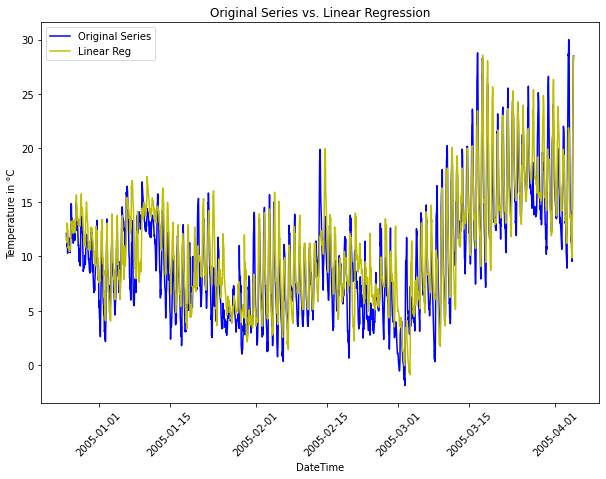

In [112]:
plt.figure(figsize=(10,7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, pipeline_lr.predict(test_X), color='y')
plt.title('Original Series vs. Linear Regression')
plt.legend(['Original Series', 'Linear Reg'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Ridge Regression

In [113]:
# Ridge Regression
mape_on_train_set = []
mape_on_val_set = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
  # print("Fold: {}".format(fold+1))
  # print("\tTRAIN indices:", train_index)
  # print("\tTEST indices:", test_index)
  X_train, X_val = train_X.iloc[train_index, :], train_X.iloc[val_index,:]
  y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

  # Construct a pipeline with standard scaler and Linear Regression
  pipeline_ridge = Pipeline(steps = [('scaler', StandardScaler()),
                               ('lr', Ridge())])
  pipeline_ridge.fit(X_train, y_train)

  train_pred = pipeline_ridge.predict(X_train)
  mae_train = mean_absolute_error(y_train, train_pred)
  mape_train = mean_absolute_percentage_error(y_train, train_pred)
  mape_on_train_set.append(mape_train)

  y_pred = pipeline_ridge.predict(X_val)
  mae_val = mean_absolute_error(y_val, y_pred)
  mape_val = mean_absolute_percentage_error(y_val, y_pred)
  mape_on_val_set.append(mape_val)


print('\nAverage MAPE on Train set: %.3f' %np.array(mape_on_train_set).mean())
print('Average MAPE on Validation set: %.3f%%' %np.array(mape_on_val_set).mean())
print('\nAverage MAE on Train set: %.3f' %np.array(mae_train).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_val).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validaition set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Average MAPE on Train set: 12.684
Average MAPE on Validation set: 13.274%

Average MAE on Train set: 2.004
Average MAE on Validation set: 2.529




,MAPE on train set,MAPE on validaition set
fold-1,17.015070,12.946860
fold-2,14.220914,8.408703
fold-3,11.774400,6.510839
fold-4,10.384349,9.131158
fold-5,10.022804,29.370824


In [114]:
# Ridge MAPE on test set
print('MAPE on test set using Ridge Regression: %.3f%%' %mean_absolute_percentage_error(pipeline_ridge.predict(test_X), test_y))
print('MAE on test set using Ridge Regression: %.3f' %mean_absolute_error(pipeline_ridge.predict(test_X), test_y))

MAPE on test set using Ridge Regression: 38.071%
MAE on test set using Ridge Regression: 2.171


In [115]:
over_under_forecast(test_y, pipeline_lr.predict(test_X))

(1581, 819, 0)

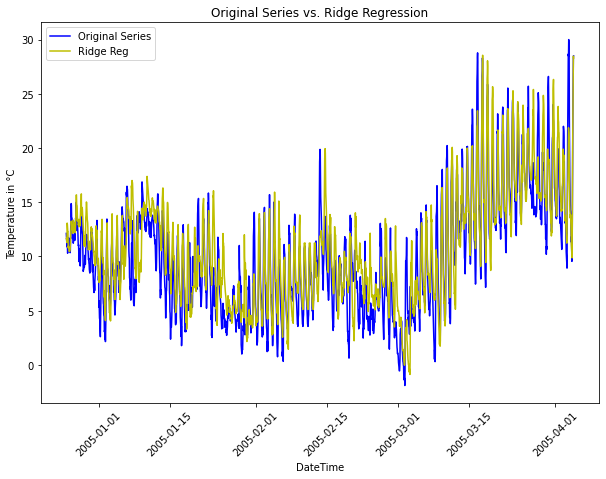

In [116]:
plt.figure(figsize=(10,7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, pipeline_ridge.predict(test_X), color='y')
plt.title('Original Series vs. Ridge Regression')
plt.legend(['Original Series', 'Ridge Reg'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Lasso Regression

In [117]:
# Lasso Regression
mape_on_val_set = []
mape_on_train_set = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
  # print("Fold: {}".format(fold+1))
  # print("\tTRAIN indices:", train_index)
  # print("\tTEST indices:", test_index)
  X_train, X_val = train_X.iloc[train_index, :], train_X.iloc[val_index,:]
  y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

  # Construct a pipeline with standard scaler and Linear Regression
  pipeline_lasso = Pipeline(steps = [('scaler', StandardScaler()),
                               ('lr', Lasso())])
  pipeline_lasso.fit(X_train, y_train)

  train_pred = pipeline_lasso.predict(X_train)
  mae_train = mean_absolute_error(y_train, train_pred)
  mape_train = mean_absolute_percentage_error(y_train, train_pred)
  mape_on_train_set.append(mape_train)

  y_pred = pipeline_lasso.predict(X_val)
  mae_val = mean_absolute_error(y_val, y_pred)
  mape_val = mean_absolute_percentage_error(y_val, y_pred)
  mape_on_val_set.append(mape_val)


print('\nAverage MAPE on Train set: %.3f' %np.array(mape_on_train_set).mean())
print('Average MAPE on Validation set: %.3f%%' %np.array(mape_on_val_set).mean())
print('\nAverage MAE on Train set: %.3f' %np.array(mae_train).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_val).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validaition set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Average MAPE on Train set: 14.003
Average MAPE on Validation set: 17.081%

Average MAE on Train set: 2.222
Average MAE on Validation set: 3.228




,MAPE on train set,MAPE on validaition set
fold-1,18.801109,15.617008
fold-2,15.439636,12.758429
fold-3,12.950937,7.473807
fold-4,11.628447,9.264630
fold-5,11.195450,40.291127


In [118]:
# Lasso MAPE on test set
print('MAPE on test set using Lasso Regression: %.3f%%' %mean_absolute_percentage_error(pipeline_lasso.predict(test_X), test_y))
print('MAE on test set using Lasso Regression: %.3f' %mean_absolute_error(pipeline_lasso.predict(test_X), test_y))

MAPE on test set using Lasso Regression: 29.664%
MAE on test set using Lasso Regression: 3.344


In [119]:
over_under_forecast(test_y, pipeline_lasso.predict(test_X))

(2081, 319, 0)

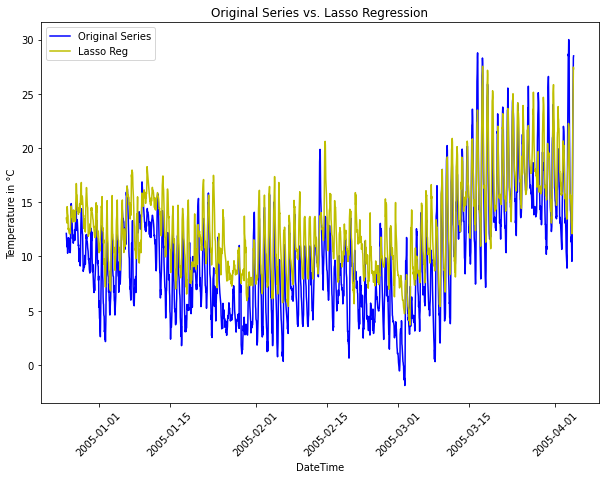

In [120]:
plt.figure(figsize=(10,7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, pipeline_lasso.predict(test_X), color='y')
plt.title('Original Series vs. Lasso Regression')
plt.legend(['Original Series', 'Lasso Reg'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### ElasticNet 

In [121]:
# ElasticNet Regression
mape_on_val_set = []
mape_on_train_set = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
  # print("Fold: {}".format(fold+1))
  # print("\tTRAIN indices:", train_index)
  # print("\tTEST indices:", test_index)
  X_train, X_val = train_X.iloc[train_index, :], train_X.iloc[val_index,:]
  y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

  # Construct a pipeline with standard scaler and Linear Regression
  pipeline_elr = Pipeline(steps = [('scaler', StandardScaler()),
                               ('lr', ElasticNet())])
  pipeline_elr.fit(X_train, y_train)

  train_pred = pipeline_elr.predict(X_train)
  mae_train = mean_absolute_error(y_train, train_pred)
  mape_train = mean_absolute_percentage_error(y_train, train_pred)
  mape_on_train_set.append(mape_train)

  y_pred = pipeline_elr.predict(X_val)
  mae_val = mean_absolute_error(y_val, y_pred)
  mape_val = mean_absolute_percentage_error(y_val, y_pred)
  mape_on_val_set.append(mape_val)


print('\nAverage MAPE on Train set: %.3f' %np.array(mape_on_train_set).mean())
print('Average MAPE on Validation set: %.3f%%' %np.array(mape_on_val_set).mean())
print('\nAverage MAE on Train set: %.3f' %np.array(mae_train).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_val).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validaition set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Average MAPE on Train set: 15.953
Average MAPE on Validation set: 22.567%

Average MAE on Train set: 2.708
Average MAE on Validation set: 4.691




,MAPE on train set,MAPE on validaition set
fold-1,19.095888,17.112423
fold-2,17.070166,17.120706
fold-3,15.460442,8.994536
fold-4,14.403350,9.776891
fold-5,13.733624,59.832540


In [122]:
# ElasticNet MAPE on test set
print('MAPE on test set using ElasticNet Regression: %.3f%%' %mean_absolute_percentage_error(pipeline_elr.predict(test_X), test_y))
print('MAE on test set using ElasticNet Regression: %.3f' %mean_absolute_error(pipeline_elr.predict(test_X), test_y))

MAPE on test set using ElasticNet Regression: 39.395%
MAE on test set using ElasticNet Regression: 5.617


In [123]:
over_under_forecast(test_y, pipeline_elr.predict(test_X))

(2283, 117, 0)

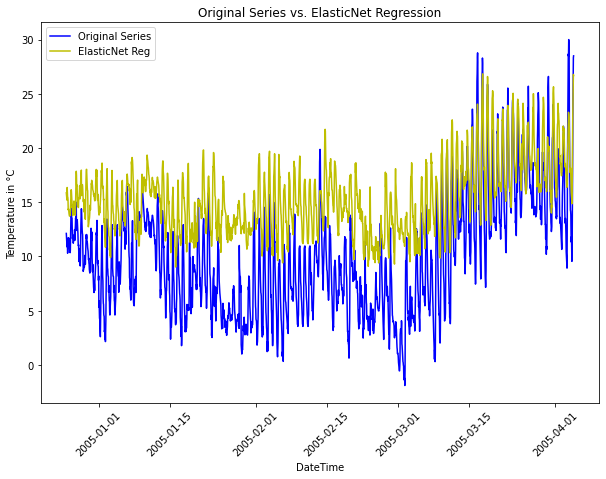

In [124]:
plt.figure(figsize=(10,7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, pipeline_elr.predict(test_X), color='y')
plt.title('Original Series vs. ElasticNet Regression')
plt.legend(['Original Series', 'ElasticNet Reg'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Decision Tree


In [125]:
eval_score = make_scorer(mean_absolute_percentage_error)

In [126]:
# DecisionTree 
pipeline_tree = Pipeline(steps = [('scaler', StandardScaler()),
                               ('dt', DecisionTreeRegressor(random_state=0))])
params = {
    'dt__criterion': ['absolute_error'],
    'dt__max_depth': [10, 15, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__max_features': ['sqrt']
}
# GridSearchCV for hyperparameter tuning
gs = GridSearchCV(pipeline_tree, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
gs.fit(train_X, train_y)
dt_best_model = gs.best_estimator_
print('\n',dt_best_model)

mape_on_train_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=eval_score)['train_score']
mape_on_val_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, scoring=eval_score)['test_score']
print('\nAverage MAPE on train set %.3f%%' %mape_on_train_set.mean())
print('Average MAPE on validation set %.3f%%' %mape_on_val_set.mean())


mae_on_train_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=make_scorer(mean_absolute_error), error_score="raise")['train_score']
mae_on_val_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=make_scorer(mean_absolute_error), error_score="raise")['test_score']
print('\nAverage MAE on Train set: %.3f' %np.array(mae_on_train_set).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_on_val_set).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validation set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Fitting 5 folds for each of 9 candidates, totalling 45 fits

 Pipeline(steps=[('scaler', StandardScaler()),
                ('dt',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                                       max_features='sqrt', random_state=0))])

Average MAPE on train set 7.817%
Average MAPE on validation set 18.127%

Average MAE on Train set: 1.379
Average MAE on Validation set: 2.955




,MAPE on train set,MAPE on validation set
fold-1,7.366061,17.195455
fold-2,8.914718,11.472456
fold-3,8.081908,8.810288
fold-4,7.142172,11.320951
fold-5,7.578198,41.837080


In [127]:
# Decision tree MAPE on test set
print('MAPE on test set using Decision Tree: %.3f%%' %mean_absolute_percentage_error(dt_best_model.predict(test_X), test_y))
print('MAE on test set using Decision Tree: %.3f' %mean_absolute_error(dt_best_model.predict(test_X), test_y))

MAPE on test set using Decision Tree: 30.170%
MAE on test set using Decision Tree: 2.771


In [128]:
over_under_forecast(test_y, dt_best_model.predict(test_X))

(1546, 854, 0)

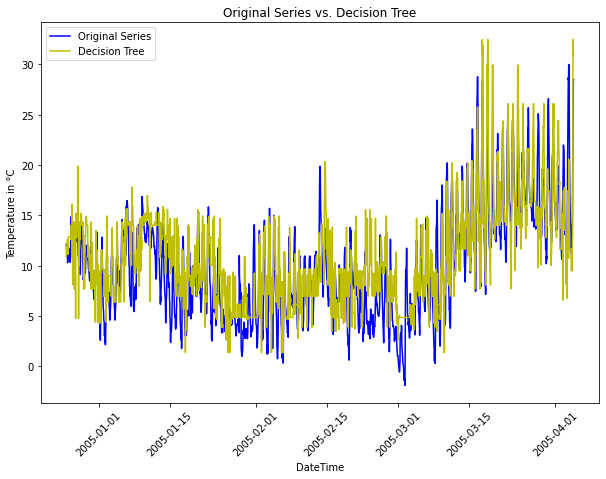

In [129]:
plt.figure(figsize=(10, 7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, dt_best_model.predict(test_X), color='y')
plt.title('Original Series vs. Decision Tree')
plt.legend(['Original Series', 'Decision Tree'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Random Forest

In [130]:
# RandomForest 
pipeline = Pipeline(steps = [('scaler', StandardScaler()),
                               ('rf', RandomForestRegressor(random_state=0))])
params = {
    'rf__n_estimators': [50, 100, 120, 150],
    'rf__max_depth': [10, 15, 20],
    'rf__min_samples_split': [2, 5, 10]
}
# GridSearchCV for hyperparameter tuning 
# rs = RandomizedSearchCV(pipeline, param_distributions=params, cv=tscv, scoring=mean_absolute_percentage_error, random_state=0, verbose=1)
gs = GridSearchCV(pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
gs.fit(train_X, train_y)
rf_best_model = gs.best_estimator_
print('\n',rf_best_model)
mape_on_train_set = cross_validate(rf_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=eval_score)['train_score']
mape_on_val_set = cross_validate(rf_best_model, train_X, train_y, cv=tscv, scoring=eval_score)['test_score']
print('\nAverage MAPE on train set %.3f%%' %mape_on_train_set.mean())
print('Average MAPE on validation set %.3f%%' %mape_on_val_set.mean())


mae_on_train_set = cross_validate(rf_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=make_scorer(mean_absolute_error), error_score="raise")['train_score']
mae_on_val_set = cross_validate(rf_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=make_scorer(mean_absolute_error), error_score="raise")['test_score']
print('\nAverage MAE on Train set: %.3f' %np.array(mae_on_train_set).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_on_val_set).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on test set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

 Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=10, min_samples_split=5,
                                       random_state=0))])

Average MAPE on train set 8.151%
Average MAPE on validation set 16.171%

Average MAE on Train set: 1.438
Average MAE on Validation set: 2.639




,MAPE on train set,MAPE on test set
fold-1,8.720375,15.259442
fold-2,9.162429,10.663239
fold-3,8.012029,7.627550
fold-4,7.391513,9.894782
fold-5,7.466663,37.410690


In [131]:
# Random Forest MAPE on test set
print('MAPE on test set using Random Forest: %.3f%%' %mean_absolute_percentage_error(rf_best_model.predict(test_X), test_y))
print('MAE on test set using Random Forest: %.3f' %mean_absolute_error(rf_best_model.predict(test_X), test_y))

MAPE on test set using Random Forest: 26.991%
MAE on test set using Random Forest: 2.504


In [132]:
over_under_forecast(test_y, rf_best_model.predict(test_X))

(1504, 896, 0)

In [133]:
# # print the indices of each fold
# for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(train_X)):
#     print("Fold {}: \n\ttrain indices = {}, \n\ttest indices = {}".format(fold_idx+1, train_idx, test_idx))

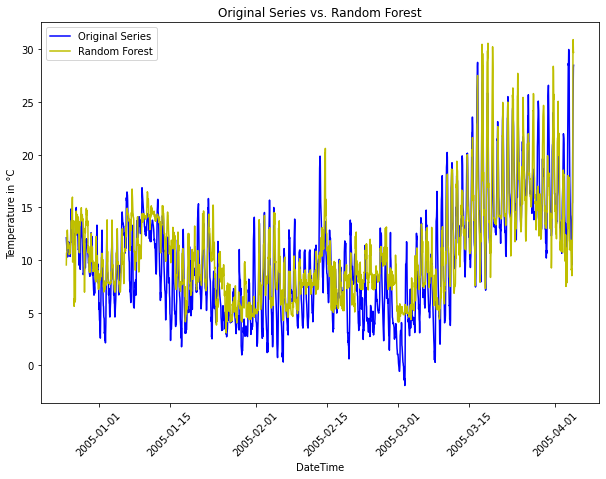

In [134]:
plt.figure(figsize=(10, 7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, rf_best_model.predict(test_X), color='y')
plt.title('Original Series vs. Random Forest')
plt.legend(['Original Series', 'Random Forest'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

## Multivariate Modeling using Cyclic Features

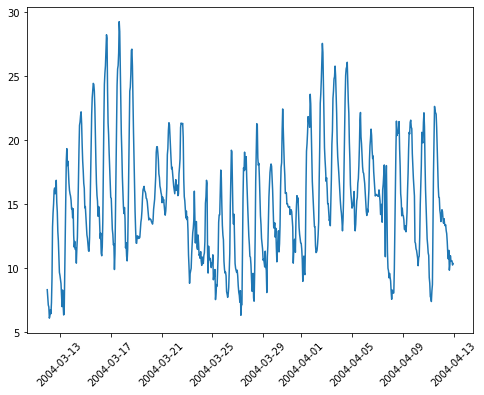

In [135]:
plt.figure(figsize=(8,6))
plt.plot(df.loc['2004-03-12 00:00:00':'2004-04-12 23:00:00'].index, 
                  df['T'].loc['2004-03-12 00:00:00':'2004-04-12 23:00:00'])
plt.xticks(rotation=45);

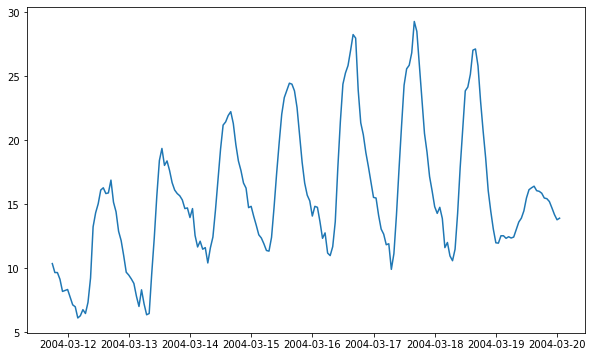

In [136]:
plt.figure(figsize=(10,6))
plt.plot(df['T'].head(200))

In [137]:
df['T'].max()

43.31875038146875

In [138]:
def cyclic_transform(data, col):
  max_val = data[col].max()
  col_norm = 2 * np.pi * data[col]/max_val
  df[col + '_sin'] = np.sin(col_norm)
  df[col + '_cos'] = np.cos(col_norm)
  return data

In [139]:
df.index.day.unique()

Int64Index([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
            28, 29, 30, 31,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
           dtype='int64', name='DateTime')

In [140]:
df['Hour'] = df.index.hour
# df['Month'] = df.index.month

In [141]:
df = cyclic_transform(df, 'Hour')
# df = cyclic_transform(df, 'Month')

In [142]:
df.columns

Index(['Date', 'Time', 'PT08.S4(NO2)', 'T', 'RH', 'AH', 'PT08.S4_lag24',
       'T_lag24', 'RH_lag24', 'AH_lag24', 'Hour', 'Month', 'season',
       'Hour_sin', 'Hour_cos'],
      dtype='object')

In [143]:
X = df[['PT08.S4_lag24', 'T_lag24', 'RH_lag24', 'AH_lag24', 'Hour_sin', 'Hour_cos']]
y = df['T']

In [144]:
# train_test_split
train_X, train_y = X.iloc[:-2400], y.iloc[:-2400]
test_X, test_y = X.iloc[-2400:], y.iloc[-2400:]

In [145]:
train_X.shape, test_X.shape

((6933, 6), (2400, 6))

### Linear Reg with cyclic features

In [146]:
# Linear Regression with 5-fold cv
mape_on_val_set = []
mape_on_train_set = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
  # print("Fold: {}".format(fold+1))
  # print("\tTRAIN indices:", train_index)
  # print("\tTEST indices:", test_index)
  X_train, X_val = train_X.iloc[train_index, :], train_X.iloc[val_index,:]
  y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

  # Construct a pipeline with standard scaler and Linear Regression
  pipeline_lr = Pipeline(
      steps = [('scaler', StandardScaler()),
                               ('lr', LinearRegression())]
  )
  pipeline_lr.fit(X_train, y_train)

  train_pred = pipeline_lr.predict(X_train)
  mae_train = mean_absolute_error(y_train, train_pred)
  mape_train = mean_absolute_percentage_error(y_train, train_pred)
  mape_on_train_set.append(mape_train)

  y_pred = pipeline_lr.predict(X_val)
  mae_val = mean_absolute_error(y_val, y_pred)
  mape_val = mean_absolute_percentage_error(y_val, y_pred)
  mape_on_val_set.append(mape_val)


print('\nAverage MAPE on Train set: %.3f%%' %np.array(mape_on_train_set).mean())
print('Average MAPE on Validation set: %.3f%%' %np.array(mape_on_val_set).mean())
print('\nAverage MAE on Train set: %.3f' %np.array(mae_train).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_val).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validaition set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Average MAPE on Train set: 12.232%
Average MAPE on Validation set: 14.648%

Average MAE on Train set: 1.994
Average MAE on Validation set: 2.676




,MAPE on train set,MAPE on validaition set
fold-1,15.341704,15.665219
fold-2,13.887816,10.576887
fold-3,11.663292,6.442521
fold-4,10.296171,9.557091
fold-5,9.968729,30.998675


In [147]:
# LR with cyclic feautres
print('MAPE on test set using Linear Regression with cyclic features: %.3f%%' %mean_absolute_percentage_error(pipeline_lr.predict(test_X), test_y))
print('MAE on test set using Linear Regression with cyclic features: %.3f' %mean_absolute_error(pipeline_lr.predict(test_X), test_y))

MAPE on test set using Linear Regression with cyclic features: 35.116%
MAE on test set using Linear Regression with cyclic features: 2.339


In [148]:
over_under_forecast(test_y, pipeline_lr.predict(test_X))

(1752, 648, 0)

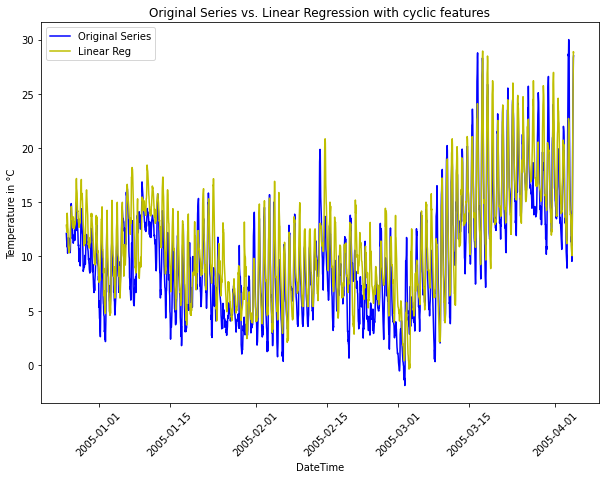

In [149]:
plt.figure(figsize=(10, 7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, pipeline_lr.predict(test_X), color='y')
plt.title('Original Series vs. Linear Regression with cyclic features')
plt.legend(['Original Series', 'Linear Reg'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Ridge Reg with cyclic features

In [150]:
# Ridge Regression
mape_on_val_set = []
mape_on_train_set = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
  # print("Fold: {}".format(fold+1))
  # print("\tTRAIN indices:", train_index)
  # print("\tTEST indices:", test_index)
  X_train, X_val = train_X.iloc[train_index, :], train_X.iloc[val_index,:]
  y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

  # Construct a pipeline with standard scaler and Linear Regression
  pipeline_ridge = Pipeline(steps = [('scaler', StandardScaler()),
                               ('lr', Ridge())])
  pipeline_ridge.fit(X_train, y_train)

  train_pred = pipeline_ridge.predict(X_train)
  mae_train = mean_absolute_error(y_train, train_pred)
  mape_train = mean_absolute_percentage_error(y_train, train_pred)
  mape_on_train_set.append(mape_train)

  y_pred = pipeline_ridge.predict(X_val)
  mae_val = mean_absolute_error(y_val, y_pred)
  mape_val = mean_absolute_percentage_error(y_val, y_pred)
  mape_on_val_set.append(mape_val)


print('\nAverage MAPE on Train set: %.3f' %np.array(mape_on_train_set).mean())
print('Average MAPE on Validation set: %.3f%%' %np.array(mape_on_val_set).mean())
print('\nAverage MAE on Train set: %.3f' %np.array(mae_train).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_val).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validaition set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Average MAPE on Train set: 12.231
Average MAPE on Validation set: 14.656%

Average MAE on Train set: 1.994
Average MAE on Validation set: 2.678




,MAPE on train set,MAPE on validaition set
fold-1,15.342541,15.669779
fold-2,13.886173,10.576224
fold-3,11.662399,6.443472
fold-4,10.295598,9.551395
fold-5,9.968428,31.040793


In [151]:
# Ridge reg with cyclic feautres
print('MAPE on test set using Ridge Regression with cyclic features: %.3f%%' %mean_absolute_percentage_error(pipeline_ridge.predict(test_X), test_y))
print('MAE on test set using Ridge Regression with cyclic features: %.3f' %mean_absolute_error(pipeline_ridge.predict(test_X), test_y))

MAPE on test set using Ridge Regression with cyclic features: 31.792%
MAE on test set using Ridge Regression with cyclic features: 2.341


In [152]:
over_under_forecast(test_y, pipeline_ridge.predict(test_X))

(1755, 645, 0)

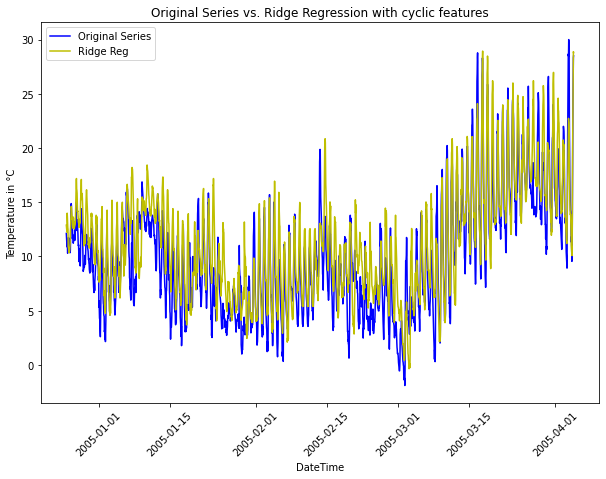

In [153]:
plt.figure(figsize=(10, 7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, pipeline_ridge.predict(test_X), color='y')
plt.title('Original Series vs. Ridge Regression with cyclic features')
plt.legend(['Original Series', 'Ridge Reg'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Lasso Reg with cyclic features 

In [154]:
# Lasso Regression
mape_on_val_set = []
mape_on_train_set = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
  # print("Fold: {}".format(fold+1))
  # print("\tTRAIN indices:", train_index)
  # print("\tTEST indices:", test_index)
  X_train, X_val = train_X.iloc[train_index, :], train_X.iloc[val_index,:]
  y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

  # Construct a pipeline with standard scaler and Linear Regression
  pipeline_lasso = Pipeline(steps = [('scaler', StandardScaler()),
                               ('lr', Lasso())])
  pipeline_lasso.fit(X_train, y_train)

  train_pred = pipeline_lasso.predict(X_train)
  mae_train = mean_absolute_error(y_train, train_pred)
  mape_train = mean_absolute_percentage_error(y_train, train_pred)
  mape_on_train_set.append(mape_train)

  y_pred = pipeline_lasso.predict(X_val)
  mae_val = mean_absolute_error(y_val, y_pred)
  mape_val = mean_absolute_percentage_error(y_val, y_pred)
  mape_on_val_set.append(mape_val)


print('\nAverage MAPE on Train set: %.3f' %np.array(mape_on_train_set).mean())
print('Average MAPE on Validation set: %.3f%%' %np.array(mape_on_val_set).mean())
print('\nAverage MAE on Train set: %.3f' %np.array(mae_train).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_val).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validaition set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Average MAPE on Train set: 13.883
Average MAPE on Validation set: 17.252%

Average MAE on Train set: 2.222
Average MAE on Validation set: 3.228




,MAPE on train set,MAPE on validaition set
fold-1,18.199485,16.472636
fold-2,15.439636,12.758429
fold-3,12.950937,7.473807
fold-4,11.628447,9.264630
fold-5,11.195450,40.291127


In [155]:
# Lasso reg with cyclic feautres
print('MAPE on test set using Lasso Regression with cyclic features: %.3f%%' %mean_absolute_percentage_error(pipeline_lasso.predict(test_X), test_y))
print('MAE on test set using Lasso Regression with cyclic features: %.3f' %mean_absolute_error(pipeline_lasso.predict(test_X), test_y))

MAPE on test set using Lasso Regression with cyclic features: 29.664%
MAE on test set using Lasso Regression with cyclic features: 3.344


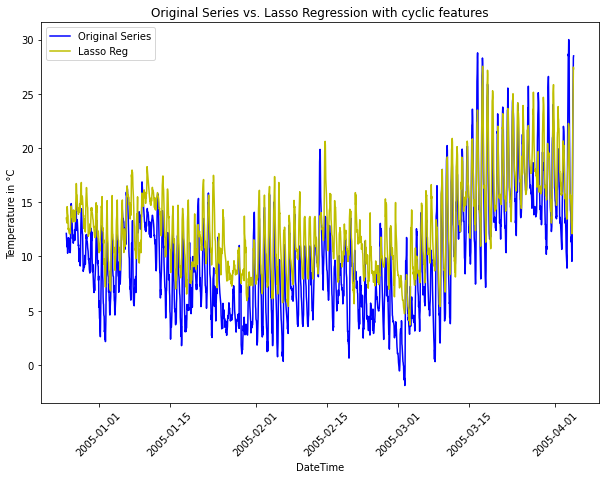

In [156]:
plt.figure(figsize=(10, 7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, pipeline_lasso.predict(test_X), color='y')
plt.title('Original Series vs. Lasso Regression with cyclic features')
plt.legend(['Original Series', 'Lasso Reg'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Decision Tree

In [157]:
# DecisionTree 
pipeline_tree = Pipeline(steps = [('scaler', StandardScaler()),
                               ('dt', DecisionTreeRegressor(random_state=0))])
params = {
    'dt__criterion': ['absolute_error'],
    'dt__max_depth': [10, 15, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__max_features': ['sqrt']
}
# GridSearchCV for hyperparameter tuning
gs = GridSearchCV(pipeline_tree, param_grid=params, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
gs.fit(train_X, train_y)
dt_best_model = gs.best_estimator_
print('\n',dt_best_model)

mape_on_train_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=eval_score)['train_score']
mape_on_val_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, scoring=eval_score)['test_score']
print('\nAverage MAPE on train set %.3f%%' %mape_on_train_set.mean())
print('Average MAPE on validation set %.3f%%' %mape_on_val_set.mean())

mae_on_train_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=make_scorer(mean_absolute_error))['train_score']
mae_on_val_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, scoring=make_scorer(mean_absolute_error))['test_score']
print('\nAverage MAE on Train set: %.3f' %np.array(mae_on_train_set).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_on_val_set).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validation set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))

Fitting 5 folds for each of 9 candidates, totalling 45 fits

 Pipeline(steps=[('scaler', StandardScaler()),
                ('dt',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=15,
                                       max_features='sqrt',
                                       min_samples_split=10, random_state=0))])

Average MAPE on train set 6.592%
Average MAPE on validation set 19.459%

Average MAE on Train set: 1.146
Average MAE on Validation set: 3.331




,MAPE on train set,MAPE on validation set
fold-1,8.055783,21.524896
fold-2,7.204998,11.991988
fold-3,6.106033,9.298941
fold-4,5.684357,14.120460
fold-5,5.910129,40.358361


In [158]:
# Decision tree MAPE on test set
print('MAPE on test set using Decison Tree: %.3f%%' %mean_absolute_percentage_error(dt_best_model.predict(test_X), test_y))
print('MAE on test set using Decision Tree: %.3f' %mean_absolute_error(dt_best_model.predict(test_X), test_y))

MAPE on test set using Decison Tree: 32.196%
MAE on test set using Decision Tree: 3.078


In [159]:
over_under_forecast(test_y, dt_best_model.predict(test_X))

(1549, 850, 1)

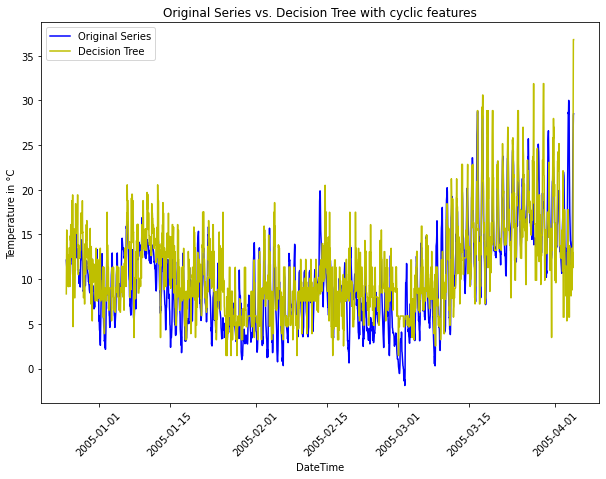

In [160]:
plt.figure(figsize=(10,7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, dt_best_model.predict(test_X), color='y')
plt.title('Original Series vs. Decision Tree with cyclic features')
plt.legend(['Original Series', 'Decision Tree'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Random Forest

In [161]:
# RandomForest 
pipeline = Pipeline(steps = [('scaler', StandardScaler()),
                               ('rf', RandomForestRegressor())])
params = {
    'rf__n_estimators': [50, 100, 120, 150],
    'rf__max_depth': [10, 15, 20],
    'rf__min_samples_split': [2, 5, 10]
}
# GridSearchCV for hyperparameter tuning 
# rs = RandomizedSearchCV(pipeline, param_distributions=params, cv=tscv, scoring=mean_absolute_percentage_error, random_state=0, verbose=1)
gs = GridSearchCV(pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
gs.fit(train_X, train_y)
rf_best_model = gs.best_estimator_
print('\n',rf_best_model)
mape_on_train_set = cross_validate(rf_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=eval_score)['train_score']
mape_on_val_set = cross_validate(rf_best_model, train_X, train_y, cv=tscv, scoring=eval_score)['test_score']
print('\nAverage MAPE on train set %.3f%%' %mape_on_train_set.mean())
print('Average MAPE on test set %.3f%%' %mape_on_val_set.mean())

mae_on_train_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=make_scorer(mean_absolute_error))['train_score']
mae_on_val_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, scoring=make_scorer(mean_absolute_error))['test_score']
print('\nAverage MAE on Train set: %.3f' %np.array(mae_on_train_set).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_on_val_set).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on test set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

 Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=10, min_samples_split=10,
                                       n_estimators=120))])

Average MAPE on train set 8.190%
Average MAPE on test set 16.953%

Average MAE on Train set: 1.146
Average MAE on Validation set: 3.331




,MAPE on train set,MAPE on test set
fold-1,8.768997,17.124669
fold-2,9.277681,10.774715
fold-3,8.063300,7.055337
fold-4,7.388549,9.992659
fold-5,7.450564,39.818216


In [162]:
# Random Forest MAPE on test set
print('MAPE on test set using Random Forest: %.3f%%' %mean_absolute_percentage_error(rf_best_model.predict(test_X), test_y))
print('MAE on test set using Random Forest: %.3f' %mean_absolute_error(rf_best_model.predict(test_X), test_y))

MAPE on test set using Random Forest: 25.953%
MAE on test set using Random Forest: 2.524


In [163]:
over_under_forecast(test_y, rf_best_model.predict(test_X))

(1599, 801, 0)

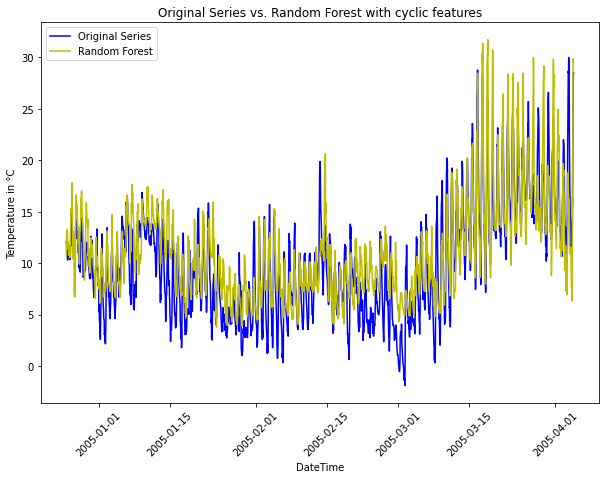

In [164]:
plt.figure(figsize=(10, 7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, rf_best_model.predict(test_X), color='y')
plt.title('Original Series vs. Random Forest with cyclic features')
plt.legend(['Original Series', 'Random Forest'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

# Categorical Features

In [174]:
# df = data[['Date', 'Time', 'PT08.S4(NO2)', 'T', 'RH', 'AH', ]]

In [175]:
df.columns

Index(['Date', 'Time', 'PT08.S4(NO2)', 'T', 'RH', 'AH', 'PT08.S4_lag24',
       'T_lag24', 'RH_lag24', 'AH_lag24', 'Hour', 'Month', 'season',
       'Hour_sin', 'Hour_cos', 'PCA'],
      dtype='object')

In [176]:
# Add categorical features for hour, month, and season
df['Hour'] = df.index.hour
df['Month'] = df.index.month
df['season'] = np.where(df['Month'].isin([3,4,5]), 'Spring',
              np.where(df['Month'].isin([6,7,8]), 'Summer',
              np.where(df['Month'].isin([9,10,11]), 'Fall', 'Winter')))

In [177]:
df.head()

,Date,Time,PT08.S4(NO2),T,RH,AH,PT08.S4_lag24,T_lag24,RH_lag24,AH_lag24,Hour,Month,season,Hour_sin,Hour_cos,PCA
DateTime,,,,,,,,,,,,,,,,
2004-03-11 18:00:00,2004-03-11,18:00:00,2083.00,10.350,64.174999,0.806544,1692.00,13.60,48.875001,0.757754,18,3,Spring,-0.979084,0.203456,-0.164205
2004-03-11 19:00:00,2004-03-11,19:00:00,2332.50,9.650,69.300001,0.831921,1558.75,13.30,47.700000,0.725487,19,3,Spring,-0.887885,0.460065,-0.420577
2004-03-11 20:00:00,2004-03-11,20:00:00,2191.25,9.650,67.750000,0.813314,1554.50,11.90,53.975000,0.750239,20,3,Spring,-0.730836,0.682553,-0.642658
2004-03-11 21:00:00,2004-03-11,21:00:00,1706.50,9.125,63.974999,0.741924,1583.75,11.00,60.000000,0.786713,21,3,Spring,-0.519584,0.854419,-0.813977
2004-03-11 22:00:00,2004-03-11,22:00:00,1332.50,8.175,63.400000,0.690484,1490.00,11.15,59.575001,0.788794,22,3,Spring,-0.269797,0.962917,-0.921828


In [178]:
df.shape

(9333, 16)

In [179]:
df2 = pd.get_dummies(df.drop(['Date', 'Time', 'PT08.S4(NO2)', 'RH', 'AH', 'season', 'Hour_sin', 'Hour_cos'], axis=1), columns=['Hour', 'Month'], prefix=['Hour_', 'Month_'])

In [180]:
df2.shape

(9333, 42)

In [181]:
df2.columns

Index(['T', 'PT08.S4_lag24', 'T_lag24', 'RH_lag24', 'AH_lag24', 'PCA',
       'Hour__0', 'Hour__1', 'Hour__2', 'Hour__3', 'Hour__4', 'Hour__5',
       'Hour__6', 'Hour__7', 'Hour__8', 'Hour__9', 'Hour__10', 'Hour__11',
       'Hour__12', 'Hour__13', 'Hour__14', 'Hour__15', 'Hour__16', 'Hour__17',
       'Hour__18', 'Hour__19', 'Hour__20', 'Hour__21', 'Hour__22', 'Hour__23',
       'Month__1', 'Month__2', 'Month__3', 'Month__4', 'Month__5', 'Month__6',
       'Month__7', 'Month__8', 'Month__9', 'Month__10', 'Month__11',
       'Month__12'],
      dtype='object')

In [182]:
X = df2.drop('T', axis=1)
y = df2['T']

In [183]:
X.shape, y.shape

((9333, 41), (9333,))

In [184]:
# # Split data into train and test sets
# X_train, X_test = X.iloc[:-2400], X.iloc[-2400:]
# y_train, y_test = y.iloc[:-2400], y.iloc[-2400:]

# train_test_split
train_X, train_y = X.iloc[:-2400], y.iloc[:-2400]
test_X, test_y = X.iloc[-2400:], y.iloc[-2400:]

### Linear Regression with dummy features


In [185]:
# Linear Regression with 5-fold cv
mape_on_val_set = []
mape_on_train_set = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
  # print("Fold: {}".format(fold+1))
  # print("\tTRAIN indices:", train_index)
  # print("\tTEST indices:", test_index)
  X_train, X_val = train_X.iloc[train_index, :], train_X.iloc[val_index,:]
  y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

  # Construct a pipeline with standard scaler and Linear Regression
  pipeline_lr = Pipeline(
      steps = [('scaler', StandardScaler()),
                               ('lr', LinearRegression())]
  )
  pipeline_lr.fit(X_train, y_train)

  train_pred = pipeline_lr.predict(X_train)
  mae_train = mean_absolute_error(y_train, train_pred)
  mape_train = mean_absolute_percentage_error(y_train, train_pred)
  mape_on_train_set.append(mape_train)

  y_pred = pipeline_lr.predict(X_val)
  mae_val = mean_absolute_error(y_val, y_pred)
  mape_val = mean_absolute_percentage_error(y_val, y_pred)
  mape_on_val_set.append(mape_val)


print('\nAverage MAPE on Train set: %.3f%%' %np.array(mape_on_train_set).mean())
print('Average MAPE on Validation set: %.3f%%' %np.array(mape_on_val_set).mean())
print('\nAverage MAE on Train set: %.3f' %np.array(mae_train).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_val).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validaition set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Average MAPE on Train set: 11.575%
Average MAPE on Validation set: 301368010448207.375%

Average MAE on Train set: 1.867
Average MAE on Validation set: 83381317291379.594




,MAPE on train set,MAPE on validaition set
fold-1,15.043064,1.722213e+14
fold-2,13.141951,4.032440e+14
fold-3,10.852477,3.430105e+13
fold-4,9.548769,5.548836e+12
fold-5,9.287737,8.915249e+14


In [186]:
mae_train

1.8670786519127842

In [187]:
# LR MAPE on test set
print('MAPE on test set using Linear Regression: %.3f%%' %mean_absolute_percentage_error(pipeline_lr.predict(test_X), test_y))
print('MAE on test set using Linear Regression: %.3f' %mean_absolute_error(pipeline_lr.predict(test_X), test_y))

MAPE on test set using Linear Regression: 72.847%
MAE on test set using Linear Regression: 110681291734495.125


In [188]:
over_under_forecast(pipeline_lr.predict(test_X), test_y)

(462, 1938, 0)

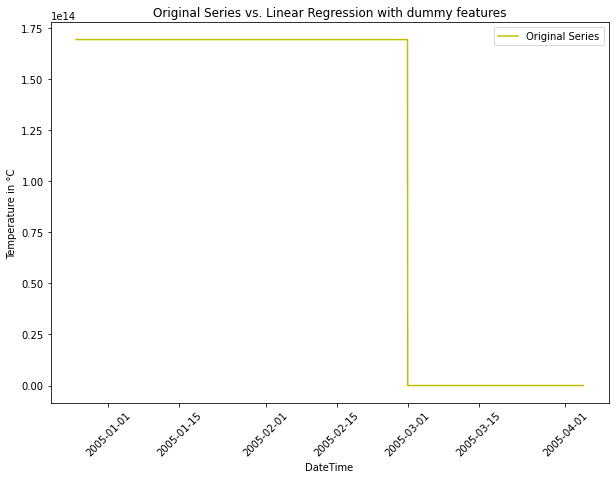

In [189]:
plt.figure(figsize=(10, 7))
# plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, pipeline_lr.predict(test_X), color='y')
plt.title('Original Series vs. Linear Regression with dummy features')
plt.legend(['Original Series', 'Linear Reg'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Ridge Reg with dummy features

In [190]:
# Ridge Regression
mape_on_val_set = []
mape_on_train_set = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
  # print("Fold: {}".format(fold+1))
  # print("\tTRAIN indices:", train_index)
  # print("\tTEST indices:", test_index)
  X_train, X_val = train_X.iloc[train_index, :], train_X.iloc[val_index,:]
  y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

  # Construct a pipeline with standard scaler and Linear Regression
  pipeline_ridge = Pipeline(steps = [('scaler', StandardScaler()),
                               ('lr', Ridge())])
  pipeline_ridge.fit(X_train, y_train)

  train_pred = pipeline_ridge.predict(X_train)
  mae_train = mean_absolute_error(y_train, train_pred)
  mape_train = mean_absolute_percentage_error(y_train, train_pred)
  mape_on_train_set.append(mape_train)

  y_pred = pipeline_ridge.predict(X_val)
  mae_val = mean_absolute_error(y_val, y_pred)
  mape_val = mean_absolute_percentage_error(y_val, y_pred)
  mape_on_val_set.append(mape_val)


print('\nAverage MAPE on Train set: %.3f' %np.array(mape_on_train_set).mean())
print('Average MAPE on Validation set: %.3f%%' %np.array(mape_on_val_set).mean())
print('\nAverage MAE on Train set: %.3f' %np.array(mae_train).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_val).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validaition set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Average MAPE on Train set: 11.545
Average MAPE on Validation set: 20.452%

Average MAE on Train set: 1.864
Average MAE on Validation set: 4.071




,MAPE on train set,MAPE on validaition set
fold-1,14.968602,16.704677
fold-2,13.080632,15.046855
fold-3,10.848713,12.242054
fold-4,9.549083,10.466286
fold-5,9.279509,47.800476


In [191]:
# Ridge Reg MAPE on test set
print('MAPE on test set using Linear Regression: %.3f%%' %mean_absolute_percentage_error(pipeline_ridge.predict(test_X), test_y))
print('MAE on test set using Linear Regression: %.3f' %mean_absolute_error(pipeline_ridge.predict(test_X), test_y))

MAPE on test set using Linear Regression: 34.972%
MAE on test set using Linear Regression: 4.246


In [192]:
over_under_forecast(pipeline_ridge.predict(test_X), test_y)

(489, 1911, 0)

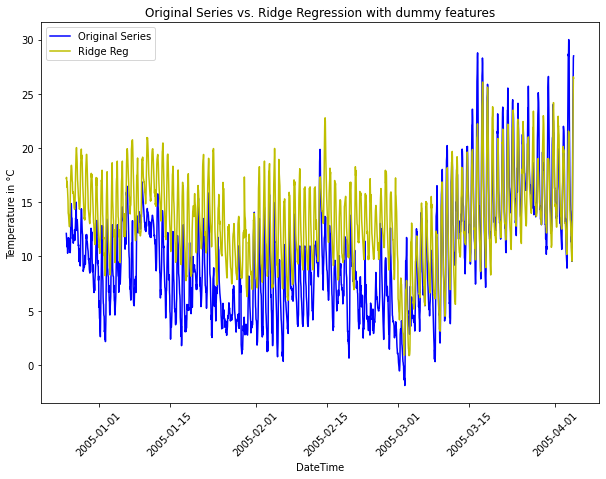

In [193]:
plt.figure(figsize=(10, 7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, pipeline_ridge.predict(test_X), color='y')
plt.title('Original Series vs. Ridge Regression with dummy features')
plt.legend(['Original Series', 'Ridge Reg'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Lasso Reg with dummy features

In [194]:
# Lasso Regression
mape_on_val_set = []
mape_on_train_set = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
  # print("Fold: {}".format(fold+1))
  # print("\tTRAIN indices:", train_index)
  # print("\tTEST indices:", test_index)
  X_train, X_val = train_X.iloc[train_index, :], train_X.iloc[val_index,:]
  y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

  # Construct a pipeline with standard scaler and Linear Regression
  pipeline_lasso = Pipeline(steps = [('scaler', StandardScaler()),
                               ('lr', Lasso())])
  pipeline_lasso.fit(X_train, y_train)

  train_pred = pipeline_lasso.predict(X_train)
  mae_train = mean_absolute_error(y_train, train_pred)
  mape_train = mean_absolute_percentage_error(y_train, train_pred)
  mape_on_train_set.append(mape_train)

  y_pred = pipeline_lasso.predict(X_val)
  mae_val = mean_absolute_error(y_val, y_pred)
  mape_val = mean_absolute_percentage_error(y_val, y_pred)
  mape_on_val_set.append(mape_val)


print('\nAverage MAPE on Train set: %.3f' %np.array(mape_on_train_set).mean())
print('Average MAPE on Validation set: %.3f%%' %np.array(mape_on_val_set).mean())
print('\nAverage MAE on Train set: %.3f' %np.array(mae_train).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_val).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validaition set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))


Average MAPE on Train set: 14.003
Average MAPE on Validation set: 17.081%

Average MAE on Train set: 2.222
Average MAE on Validation set: 3.228




,MAPE on train set,MAPE on validaition set
fold-1,18.801109,15.617008
fold-2,15.439636,12.758429
fold-3,12.950937,7.473807
fold-4,11.628447,9.264630
fold-5,11.195450,40.291127


In [195]:
# Ridge reg with cyclic feautres
print('MAPE on test set using Lasso Regression with cyclic features: %.3f%%' %mean_absolute_percentage_error(pipeline_lasso.predict(test_X), test_y))
print('MAE on test set using Lasso Regression with cyclic features: %.3f' %mean_absolute_error(pipeline_lasso.predict(test_X), test_y))

MAPE on test set using Lasso Regression with cyclic features: 29.664%
MAE on test set using Lasso Regression with cyclic features: 3.344


In [196]:
over_under_forecast(pipeline_lasso.predict(test_X), test_y)

(319, 2081, 0)

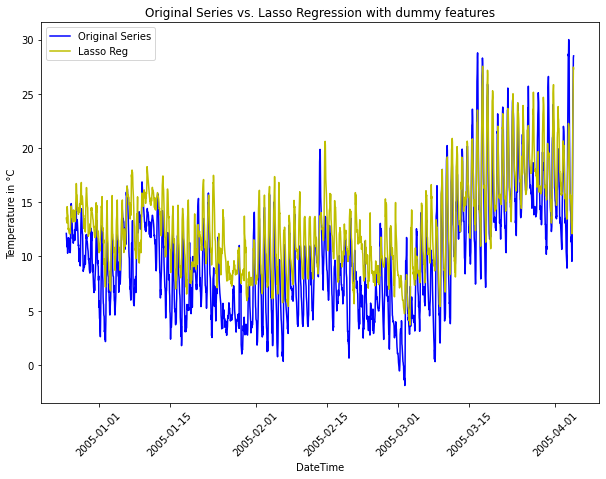

In [197]:
plt.figure(figsize=(10, 7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, pipeline_lasso.predict(test_X), color='y')
plt.title('Original Series vs. Lasso Regression with dummy features')
plt.legend(['Original Series', 'Lasso Reg'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Decision Tree with dummy features


In [198]:
# DecisionTree 
pipeline_tree = Pipeline(steps = [('scaler', StandardScaler()),
                               ('dt', DecisionTreeRegressor(random_state=0))])
params = {
    'dt__criterion': ['absolute_error'],
    'dt__max_depth': [10, 15, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__max_features': ['sqrt']
}
# GridSearchCV for hyperparameter tuning
gs = GridSearchCV(pipeline_tree, param_grid=params, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
gs.fit(train_X, train_y)
dt_best_model = gs.best_estimator_
print('\n',dt_best_model)

mape_on_train_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=eval_score)['train_score']
mape_on_val_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, scoring=eval_score)['test_score']
print('\nAverage MAPE on train set %.3f%%' %mape_on_train_set.mean())
print('Average MAPE on validation set %.3f%%' %mape_on_val_set.mean())

mae_on_train_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=make_scorer(mean_absolute_error))['train_score']
mae_on_val_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, scoring=make_scorer(mean_absolute_error))['test_score']
print('\nAverage MAE on Train set: %.3f' %np.array(mae_on_train_set).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_on_val_set).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on validation set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))

Fitting 5 folds for each of 9 candidates, totalling 45 fits

 Pipeline(steps=[('scaler', StandardScaler()),
                ('dt',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=15,
                                       max_features='sqrt', min_samples_split=5,
                                       random_state=0))])

Average MAPE on train set 6.944%
Average MAPE on validation set 25.391%

Average MAE on Train set: 1.197
Average MAE on Validation set: 4.252




,MAPE on train set,MAPE on validation set
fold-1,9.721829,19.084202
fold-2,7.005526,21.351860
fold-3,6.203508,11.048673
fold-4,5.885303,13.349010
fold-5,5.904404,62.120782


In [199]:
# Decision tree MAPE on test set
print('MAPE on test set using Decison Tree: %.3f%%' %mean_absolute_percentage_error(dt_best_model.predict(test_X), test_y))
print('MAE on test set using Decision Tree: %.3f' %mean_absolute_error(dt_best_model.predict(test_X), test_y))

MAPE on test set using Decison Tree: 44.684%
MAE on test set using Decision Tree: 7.291


In [200]:
over_under_forecast(dt_best_model.predict(test_X), test_y)

(436, 1964, 0)

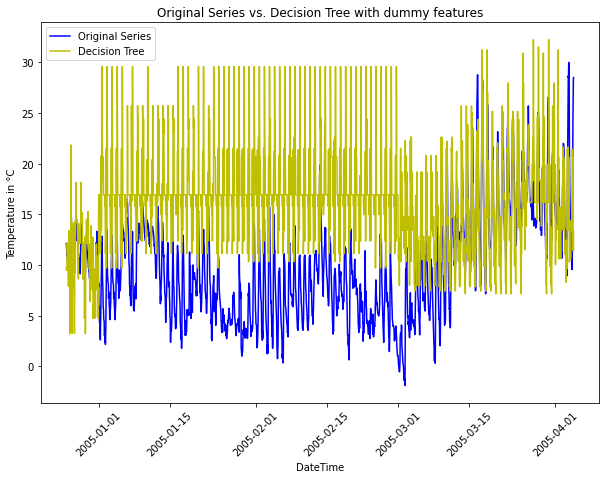

In [201]:
plt.figure(figsize=(10, 7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, dt_best_model.predict(test_X), color='y')
plt.title('Original Series vs. Decision Tree with dummy features')
plt.legend(['Original Series', 'Decision Tree'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

### Random Forest with dummy features

In [202]:
# RandomForest 
pipeline = Pipeline(steps = [('scaler', StandardScaler()),
                               ('rf', RandomForestRegressor())])
params = {
    'rf__n_estimators': [50, 100, 120, 150],
    'rf__max_depth': [10, 15, 20],
    'rf__min_samples_split': [2, 5, 10]
}
# GridSearchCV for hyperparameter tuning 
# rs = RandomizedSearchCV(pipeline, param_distributions=params, cv=tscv, scoring=mean_absolute_percentage_error, random_state=0, verbose=1)
gs = GridSearchCV(pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
gs.fit(train_X, train_y)
rf_best_model = gs.best_estimator_
print('\n',rf_best_model)
mape_on_train_set = cross_validate(rf_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=eval_score)['train_score']
mape_on_val_set = cross_validate(rf_best_model, train_X, train_y, cv=tscv, scoring=eval_score)['test_score']
print('\nAverage MAPE on train set %.3f%%' %mape_on_train_set.mean())
print('Average MAPE on test set %.3f%%' %mape_on_val_set.mean())

mae_on_train_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, return_train_score=True, scoring=make_scorer(mean_absolute_error))['train_score']
mae_on_val_set = cross_validate(dt_best_model, train_X, train_y, cv=tscv, scoring=make_scorer(mean_absolute_error))['test_score']
print('\nAverage MAE on Train set: %.3f' %np.array(mae_on_train_set).mean())
print('Average MAE on Validation set: %.3f' %np.array(mae_on_val_set).mean())
print('\n')
display(pd.DataFrame({'MAPE on train set': mape_on_train_set,
              'MAPE on test set': mape_on_val_set}).set_index(pd.Index(['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5'])))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

 Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=10, min_samples_split=10,
                                       n_estimators=50))])

Average MAPE on train set 8.201%
Average MAPE on test set 18.453%

Average MAE on Train set: 1.197
Average MAE on Validation set: 4.252




,MAPE on train set,MAPE on test set
fold-1,8.929503,15.203936
fold-2,9.146026,11.649363
fold-3,8.044357,7.048210
fold-4,7.445908,9.776446
fold-5,7.439851,48.585392


In [204]:
# Random Forest MAPE on test set
print('MAPE on test set using Random Forest: %.3f%%' %mean_absolute_percentage_error(rf_best_model.predict(test_X), test_y))
print('MAE on test set using Random Forest: %.3f' %mean_absolute_error(rf_best_model.predict(test_X), test_y))

MAPE on test set using Random Forest: 26.347%
MAE on test set using Random Forest: 2.449


In [205]:
over_under_forecast(rf_best_model.predict(test_X), test_y)

(854, 1546, 0)

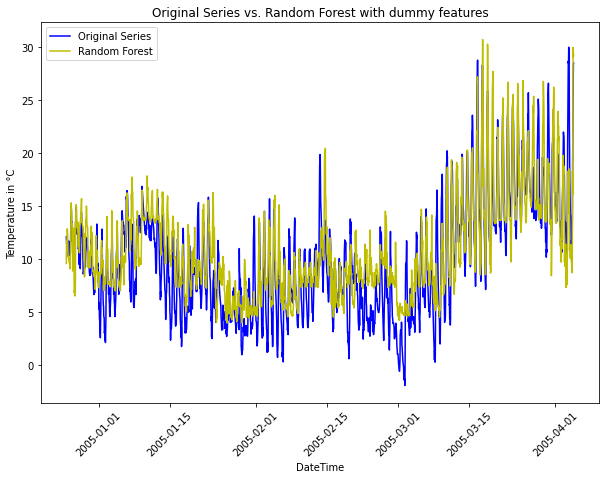

In [206]:
plt.figure(figsize=(10, 7))
plt.plot(test_y.index, test_y.values, color='b')
plt.plot(test_y.index, rf_best_model.predict(test_X), color='y')
plt.title('Original Series vs. Random Forest with dummy features')
plt.legend(['Original Series', 'Random Forest'])
plt.ylabel('Temperature in °C')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.show()

In [207]:
models = ['LR lag', 'Ridge lag', 'Lasso Lag', 'DT lag', 'RF lag', 
          'LR cyclic', 'Ridge cyclic', 'Lasso cyclic', 'DT cyclic', 'RF cyclic'
          'LR dummy', 'Ridge dummy', 'Lasso dummy', 'DT dummy', 'RF dummy']

mape_score_on_test_set = [] 

colors = plt.cm.Set1(np.arange(len(models)))


In [210]:
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(models, mape_score_on_test_set, color=colors)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE Score')
ax.set_title('Comparison of MAE Scores for Temperature Forecasting Models')
plt.xticks(rotation=45, ha='right');

In [211]:
palette = sns.color_palette("muted")
plt.figure(figsize=(7,5))
sns.barplot(x=models, y=mape_score_on_test_set, palette=palette)
plt.xlabel('Models')
plt.ylabel('MAPE Score')
plt.xticks(rotation=45, ha='right')
plt.title('Comparison of MAPE scores on test set');